### Grunfeld Data

In [ ]:
import pandas as pd
from stargazer.stargazer import Stargazer
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('data/grunfeld.csv')
print(df.firm.nunique(), df.year.nunique())
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
selected_firms = ["General Motors", "US Steel", "General Electric", "Chrysler", "Atlantic Refining"]
data5firms = df[df['firm'].isin(selected_firms)]
plt.figure(figsize=(10, 6))
sns.lineplot(data=data5firms, x='year', y='invest', hue='firm', marker='o')
plt.xlabel("Years")
plt.ylabel("Gross Investment")
plt.title("Gross investment over the years 1935-1954")
plt.legend(title='Firms')
plt.show()

### pooled and cross-sectional ols

In [ ]:
# OLS on data from year 1935
df_1935 = df[df['year'] == 1935]
X_1935 = sm.add_constant(df_1935[['value', 'capital']])
y_1935 = df_1935['invest']
reg1 = sm.OLS(y_1935, X_1935).fit()

# Pooled OLS
X_pooled = sm.add_constant(df[['value', 'capital']])
y_pooled = df['invest']
reg2 = sm.OLS(y_pooled, X_pooled).fit()

stargazer = Stargazer([reg1, reg2])
display(stargazer)

### unobserved heterogeneity accross firms and time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and the grid layout
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot 1: Unobserved heterogeneity across firms
sns.scatterplot(data=df, x='value', y='invest', hue='firm', palette='tab10', ax=axes[0])
for firm in df['firm'].unique():
    firm_data = df[df['firm'] == firm]
    sns.regplot(data=firm_data, x='value', y='invest', scatter=False, ci=None, ax=axes[0])
axes[0].set_title('Unobserved Heterogeneity Across Firms')
axes[0].set_xlabel('Firm Value')
axes[0].set_ylabel('Gross Investment')
axes[0].legend(title='Firm')

# Plot 2: Unobserved heterogeneity over time
sns.scatterplot(data=df, x='value', y='invest', hue='year', palette='tab10', ax=axes[1])
for year in df['year'].unique():
    year_data = df[df['year'] == year]
    sns.regplot(data=year_data, x='value', y='invest', scatter=False, ci=None, ax=axes[1])
axes[1].set_title('Unobserved Heterogeneity Over Time')
axes[1].set_xlabel('Firm Value')
axes[1].set_ylabel('Gross Investment')
axes[1].legend(title='Year')

# Adjust layout
plt.tight_layout()
plt.show()


### first-difference estimator

In [ ]:
df = df.sort_values(by=['firm', 'year'])
df['invest_diff'] = df.groupby('firm')['invest'].diff()
df['value_diff'] = df.groupby('firm')['value'].diff()
df['capital_diff'] = df.groupby('firm')['capital'].diff()
df_diff = df.dropna()
X_diff = df_diff[['value_diff', 'capital_diff']]
X_diff = sm.add_constant(X_diff)
y_diff = df_diff['invest_diff']
reg_diff = sm.OLS(y_diff, X_diff).fit()
print(reg_diff.summary())

### dummy variable fixed effects ols

In [ ]:
df = pd.read_csv('data/grunfeld.csv')
df = df.sort_values(by=['firm', 'year'])
largest_firm = df['firm'].value_counts().idxmax()
df = pd.get_dummies(df, columns=['firm'], drop_first=True)
firm_dummies = [col for col in df.columns if col.startswith('firm_')]
X = df[['value', 'capital'] + firm_dummies].apply(pd.to_numeric, errors='coerce')
X[firm_dummies] = X[firm_dummies].astype(int)  # Convert dummies to integers
y = df['invest'].apply(pd.to_numeric, errors='coerce')
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns='invest')
y = df_clean['invest']
X = sm.add_constant(X)
reg = sm.OLS(y, X).fit()
print(reg.summary())

### within estimator (no dummies)

In [ ]:
df = pd.read_csv('data/grunfeld.csv')
df = df.sort_values(by=['firm', 'year'])
df['invest_demean'] = df['invest'] - df.groupby('firm')['invest'].transform('mean')
df['value_demean'] = df['value'] - df.groupby('firm')['value'].transform('mean')
df['capital_demean'] = df['capital'] - df.groupby('firm')['capital'].transform('mean')
X_demean = df[['value_demean', 'capital_demean']]
#X_demean = sm.add_constant(X_demean)
y_demean = df['invest_demean']
df_clean = pd.concat([X_demean, y_demean], axis=1).dropna()
X_demean = df_clean.drop(columns='invest_demean')
y_demean = df_clean['invest_demean']
reg_demean = sm.OLS(y_demean, X_demean).fit()
print(reg_demean.summary())

### time and fixed effects

In [ ]:
df = pd.read_csv('data/grunfeld.csv')
df = df.sort_values(by=['firm', 'year'])
largest_firm = df['firm'].value_counts().idxmax()
df = pd.get_dummies(df, columns=['firm', 'year'], drop_first=True)
firm_dummies = [col for col in df.columns if col.startswith('firm_')]
year_dummies = [col for col in df.columns if col.startswith('year_')]
X = df[['value', 'capital'] + firm_dummies + year_dummies].apply(pd.to_numeric, errors='coerce')
X[firm_dummies + year_dummies] = X[firm_dummies + year_dummies].astype(int)  # Convert dummies to integers
y = df['invest'].apply(pd.to_numeric, errors='coerce')
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns='invest')
y = df_clean['invest']
X = sm.add_constant(X)
reg = sm.OLS(y, X).fit()
print(reg.summary())

### twfe estimator (de-meaned)

In [ ]:
df = pd.read_csv('data/grunfeld.csv')
df = df.sort_values(by=['firm', 'year'])

# Step 1: Demean by firm (subtract the mean within each firm)
df['value_demeaned_firm'] = df['value'] - df.groupby('firm')['value'].transform('mean')
df['capital_demeaned_firm'] = df['capital'] - df.groupby('firm')['capital'].transform('mean')
df['invest_demeaned_firm'] = df['invest'] - df.groupby('firm')['invest'].transform('mean')

# Step 2: Demean by year (subtract the mean within each year, after demeaning by firms)
df['value_demeaned'] = df['value_demeaned_firm'] - df.groupby('year')['value_demeaned_firm'].transform('mean')
df['capital_demeaned'] = df['capital_demeaned_firm'] - df.groupby('year')['capital_demeaned_firm'].transform('mean')
df['invest_demeaned'] = df['invest_demeaned_firm'] - df.groupby('year')['invest_demeaned_firm'].transform('mean')

# Prepare the demeaned X and y
X_demeaned = df[['value_demeaned', 'capital_demeaned']]
X_demeaned = sm.add_constant(X_demeaned)
y_demeaned = df['invest_demeaned']

# Drop rows with missing values
df_clean = pd.concat([X_demeaned, y_demeaned], axis=1).dropna()
X_demeaned = df_clean.drop(columns='invest_demeaned')
y_demeaned = df_clean['invest_demeaned']

# Fit the OLS regression model with doubly demeaned variables
reg_demeaned = sm.OLS(y_demeaned, X_demeaned).fit()
print(reg_demeaned.summary())

### summary

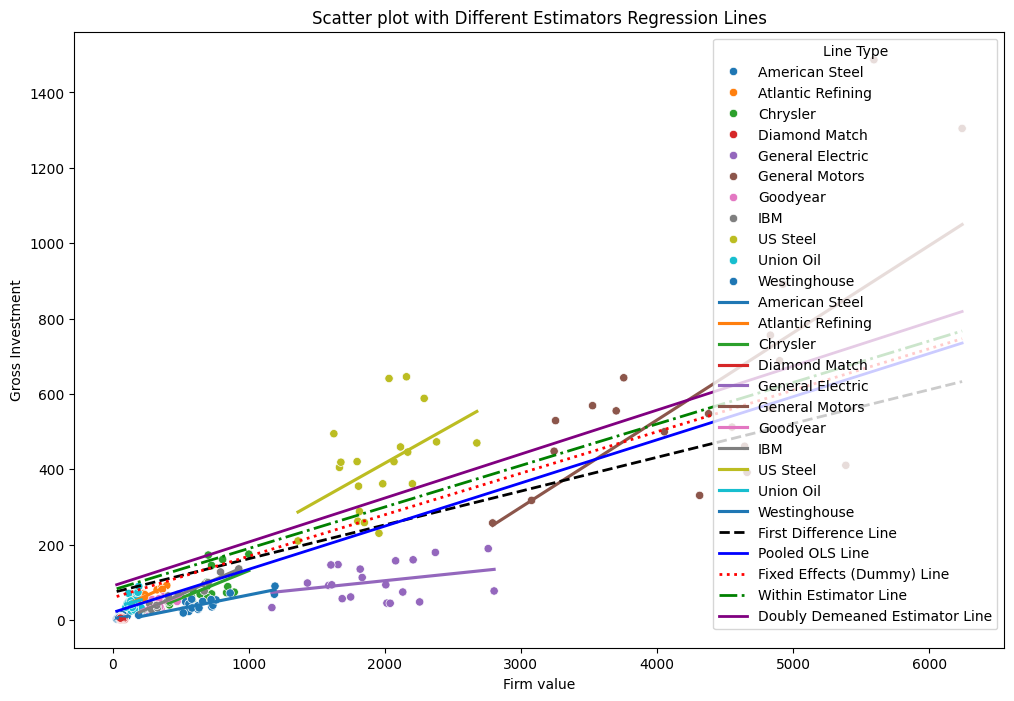

In [32]:
df = pd.read_csv('data/grunfeld.csv')
df = df.sort_values(by=['firm', 'year'])

# Create first differences for the first-difference estimator
df['invest_diff'] = df.groupby('firm')['invest'].diff()
df['value_diff'] = df.groupby('firm')['value'].diff()
df['capital_diff'] = df.groupby('firm')['capital'].diff()
df_diff = df.dropna()

# Fit the first differences regression model
X_diff = df_diff[['value_diff', 'capital_diff']]
X_diff = sm.add_constant(X_diff)
y_diff = df_diff['invest_diff']
reg_diff = sm.OLS(y_diff, X_diff).fit()

# Extract coefficients for the first differences model
intercept_diff, coef_value_diff, coef_capital_diff = reg_diff.params

# Prepare the data for the pooled OLS model
df_pooled = df.copy()
X_pooled = df_pooled[['value', 'capital']]
X_pooled = sm.add_constant(X_pooled)
y_pooled = df_pooled['invest']
reg_pooled = sm.OLS(y_pooled, X_pooled).fit()

# Extract coefficients for the pooled OLS model
intercept_pooled, coef_value_pooled, coef_capital_pooled = reg_pooled.params

# Fit the dummy variable fixed effects model
df_dummies = pd.get_dummies(df, columns=['firm'], drop_first=True)
firm_dummies = [col for col in df_dummies.columns if col.startswith('firm_')]
X_dummies = df_dummies[['value', 'capital'] + firm_dummies]
X_dummies = sm.add_constant(X_dummies)

# Ensure all dummy variables are treated as integers
X_dummies[firm_dummies] = X_dummies[firm_dummies].astype(int)

# Convert other columns to numeric if needed
for col in ['value', 'capital']:
    X_dummies[col] = pd.to_numeric(X_dummies[col], errors='coerce')

y_dummies = df_dummies['invest'].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X_dummies = X_dummies.dropna()
y_dummies = y_dummies[X_dummies.index]

# Fit the OLS model with dummy variables
reg_dummies = sm.OLS(y_dummies, X_dummies).fit()

# Extract coefficients for the dummy variable model (ignoring firm dummies)
intercept_dummies = reg_dummies.params['const']
coef_value_dummies = reg_dummies.params['value']
coef_capital_dummies = reg_dummies.params['capital']

# Fit the within estimator model (demeaning)
df['invest_demean'] = df['invest'] - df.groupby('firm')['invest'].transform('mean')
df['value_demean'] = df['value'] - df.groupby('firm')['value'].transform('mean')
df['capital_demean'] = df['capital'] - df.groupby('firm')['capital'].transform('mean')
X_demean = df[['value_demean', 'capital_demean']]
X_demean = sm.add_constant(X_demean)
y_demean = df['invest_demean']
df_clean = pd.concat([X_demean, y_demean], axis=1).dropna()
X_demean = df_clean.drop(columns='invest_demean')
y_demean = df_clean['invest_demean']
reg_demean = sm.OLS(y_demean, X_demean).fit()

# Extract coefficients for the within estimator model
intercept_demean, coef_value_demean, coef_capital_demean = reg_demean.params

# Fit the doubly demeaned estimator model
df['value_demeaned_firm'] = df['value'] - df.groupby('firm')['value'].transform('mean')
df['capital_demeaned_firm'] = df['capital'] - df.groupby('firm')['capital'].transform('mean')
df['invest_demeaned_firm'] = df['invest'] - df.groupby('firm')['invest'].transform('mean')

df['value_demeaned'] = df['value_demeaned_firm'] - df.groupby('year')['value_demeaned_firm'].transform('mean')
df['capital_demeaned'] = df['capital_demeaned_firm'] - df.groupby('year')['capital_demeaned_firm'].transform('mean')
df['invest_demeaned'] = df['invest_demeaned_firm'] - df.groupby('year')['invest_demeaned_firm'].transform('mean')

X_demeaned = df[['value_demeaned', 'capital_demeaned']]
X_demeaned = sm.add_constant(X_demeaned)
y_demeaned = df['invest_demeaned']

df_clean_demeaned = pd.concat([X_demeaned, y_demeaned], axis=1).dropna()
X_demeaned = df_clean_demeaned.drop(columns='invest_demeaned')
y_demeaned = df_clean_demeaned['invest_demeaned']

reg_demeaned = sm.OLS(y_demeaned, X_demeaned).fit()

# Extract coefficients for the doubly demeaned estimator model
intercept_demeaned, coef_value_demeaned_firm_year, coef_capital_demeaned_firm_year = reg_demeaned.params

# Create the scatter plot with firm-specific regression lines
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='value', y='invest', hue='firm', palette='tab10')
for firm in df['firm'].unique():
    firm_data = df[df['firm'] == firm]
    sns.regplot(data=firm_data, x='value', y='invest', scatter=False, ci=None, label=firm)

# Plot the regression lines for each estimator
value_range = np.linspace(df['value'].min(), df['value'].max(), 100)
mean_capital = df['capital'].mean()

# First-difference regression line
reg_line_diff = intercept_diff + coef_value_diff * value_range + coef_capital_diff * mean_capital
plt.plot(value_range, reg_line_diff, color='black', linestyle='--', linewidth=2, label='First Difference Line')

# Pooled OLS regression line
reg_line_pooled = intercept_pooled + coef_value_pooled * value_range + coef_capital_pooled * mean_capital
plt.plot(value_range, reg_line_pooled, color='blue', linestyle='-', linewidth=2, label='Pooled OLS Line')

# Dummy variable fixed effects regression line
reg_line_dummies = intercept_dummies + coef_value_dummies * value_range + coef_capital_dummies * mean_capital
plt.plot(value_range, reg_line_dummies, color='red', linestyle=':', linewidth=2, label='Fixed Effects (Dummy) Line')

# Within estimator regression line
reg_line_demean = intercept_demean + coef_value_demean * value_range + coef_capital_demean * mean_capital
plt.plot(value_range, reg_line_demean, color='green', linestyle='-.', linewidth=2, label='Within Estimator Line')

# Doubly demeaned estimator regression line
reg_line_doubly_demean = intercept_demeaned + coef_value_demeaned_firm_year * value_range + coef_capital_demeaned_firm_year * mean_capital
plt.plot(value_range, reg_line_doubly_demean, color='purple', linestyle='-', linewidth=2, label='Doubly Demeaned Estimator Line')

# Plot settings
plt.xlabel('Firm value')
plt.ylabel('Gross Investment')
plt.legend(title='Line Type')
plt.title('Scatter plot with Different Estimators Regression Lines')
plt.show()


### Wage Panel

In [39]:
from linearmodels.datasets import wage_panel
data = wage_panel.load()
data = data.set_index(["nr", "year"])
formulas = {
    "Pooled OLS": "lwage ~ married + expersq + union + hours",
    "Fixed Effects OLS": "lwage ~ married + expersq + union + hours + EntityEffects",
    "TWFE": "lwage ~ married + expersq + union + hours + EntityEffects + TimeEffects",
}
results = {}
for model_name, formula in formulas.items():
    mod = PanelOLS.from_formula(formula, data=data)
    results[model_name] = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True if 'TimeEffects' in formula else False)
summary_table = pd.DataFrame({
    model_name: {
        param: res.params[param]
        for param in res.params.index
    } for model_name, res in results.items()
}).T
display(summary_table)

,expersq,hours,married,union
Pooled OLS,0.002646,0.000577,0.183050,0.329152
Fixed Effects OLS,0.003951,-0.000085,0.114654,0.078444
TWFE,-0.006239,-0.000136,0.047623,0.072673
